In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from __future__ import annotations
from typing import Any, Callable, List, Optional, Tuple

import os
import sys
sys.path.append("../") # So we can use the coordination package
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

from copy import deepcopy
import arviz as az
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import seaborn as sns

from coordination.model.real.brain import BrainModel
from coordination.model.config_bundle.brain import BrainBundle
from coordination.model.model import ModelSamples
from coordination.inference.inference_data import InferenceData

# Style

In [4]:
sns.set_style("white")
tex_fonts = {
    "axes.labelsize": 8,
    "font.size": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 6,
    "ytick.labelsize": 6,
    "axes.titlesize": 8,
    "axes.linewidth": 1
}
plt.rcParams.update(tex_fonts)
plt.rc('pdf',fonttype = 42)
plt.rcParams['text.usetex'] = True

# Use \showthe\textwidth
DOC_WIDTH = int(487.8225)

## Helper functions

In [5]:
def calculate_best_figure_dimensions(document_width: Union[str, float], scale=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.
    From: https://jwalton.info/Embed-Publication-Matplotlib-Latex/

    Parameters
    ----------
    document_width: Union[str, float]
            Document textwidth or columnwidth in pts. Predefined strings are also acceptable.
    scale: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    width_pt = document_width

    # Width of figure (in pts)
    fig_width_pt = width_pt * scale

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5 ** .5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt

    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return fig_width_in, fig_height_in

# Constants

In [6]:
SEED = 0
T = 30

# Models

In [7]:
# Config bundle for a model of fNIRS with two features
def get_config_bundle(num_time_steps, 
                      coordination, 
                      constant_coordination, 
                      process_noise = 0, 
                      observation_noise = 0,
                      common_cause = False):
    bundle = BrainBundle()
    bundle.num_time_steps_in_coordination_scale = num_time_steps
    bundle.num_fnirs_channels = 2
    bundle.fnirs_channel_names = ["Channel1", "Channel2"]
    
    # Hyper-prior parameters
    bundle.sd_sd_uc = 0.1
    bundle.sd_mean_uc0 = 1.0
    bundle.sd_mean_a0 = 1.0
    bundle.fnirs_share_mean_a0_across_subjects = False
    bundle.fnirs_share_mean_a0_across_dimensions = False    
    bundle.common_cause = common_cause
    
    # Parameters
    bundle.mean_cc0 = np.array([[1.0, 3.0]])
    bundle.sd_cc=process_noise
    bundle.fnirs_mean_a0 = np.array([[0.0, 1.0], [1, 2.0], [2, 3.0]])
    bundle.fnirs_sd_a = process_noise
    bundle.fnirs_sd_o = observation_noise
    bundle.mean_uc0 = 0.0
    bundle.sd_uc = 0.1
        
    # Fix coordination samples so we can generate samples for a fixed coordination series.
    if constant_coordination:
        bundle.constant_coordination = True
        bundle.initial_coordination_samples = np.ones((1, num_time_steps)) * coordination
    else:
        if isinstance(coordination, np.ndarray):
            coordination_series = coordination
        else:
            coordination_series = np.ones(num_time_steps) * coordination
        bundle.initial_coordination_samples = coordination_series[None, :]

    return bundle

model_low_c_and_cc = BrainModel(get_config_bundle(T, 0.2, False, process_noise = 0.01, observation_noise = 0.01, common_cause=True))
data_low_c_and_cc = model_low_c_and_cc.draw_samples()

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 3 dimension(s)

NameError: name 'data_low_c_and_cc' is not defined

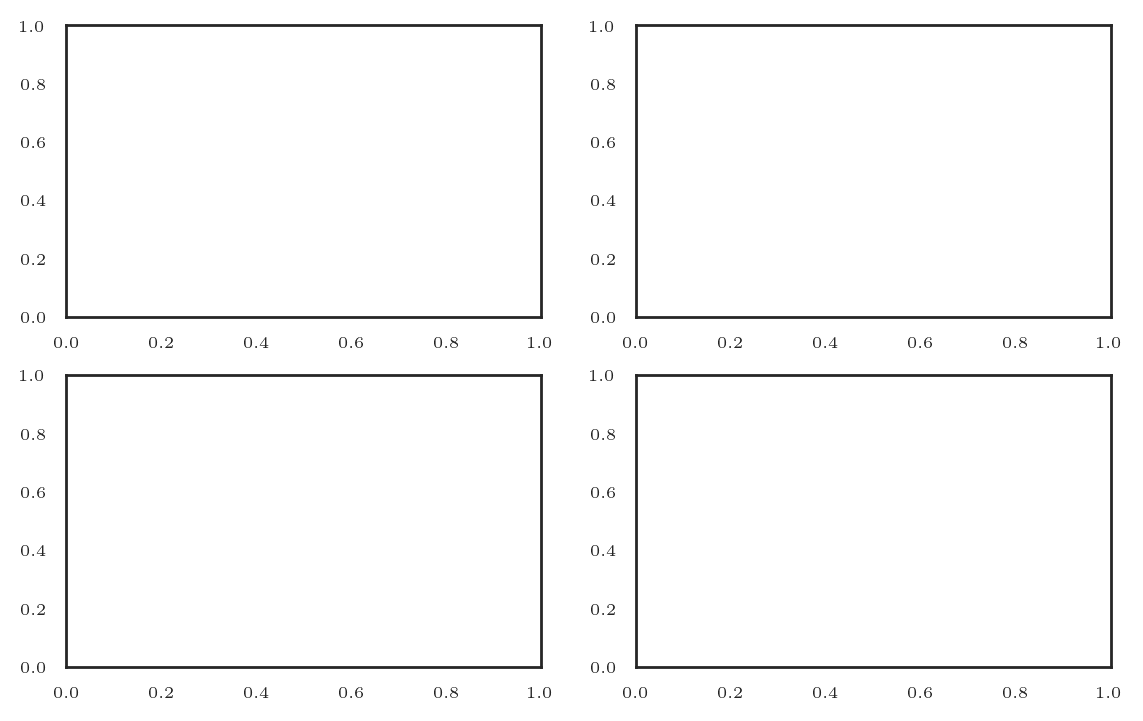

In [8]:
def plot_common_cause(samples: ModelSamples, ax: Optional[plt.Axes] = None):
    if ax is None:
        ax = plt.figure(figsize=calculate_best_figure_dimensions(DOC_WIDTH)).gca()
    
    ax.plot(range(T), samples.component_group_samples['common_cause_fnirs_state_space'].values[0, 0, 0], "o-", label="Position", markersize=3)
    ax.plot(range(T), samples.component_group_samples['common_cause_fnirs_state_space'].values[0, 0, 1], "o-", label="Velocity", markersize=3)
    
def plot_latent_component(samples: ModelSamples, subject_idx: int, ax: Optional[plt.Axes] = None):
    if ax is None:
        ax = plt.figure(figsize=calculate_best_figure_dimensions(DOC_WIDTH)).gca()
    
    ax.plot(range(T), samples.component_group_samples['fnirs_state_space'].values[0, subject_idx, 0], "o-", label="Position", markersize=3)
    ax.plot(range(T), samples.component_group_samples['fnirs_state_space'].values[0, subject_idx, 1], "o-", label="Velocity", markersize=3)
    
fig, axs = plt.subplots(2, 2, figsize=calculate_best_figure_dimensions(DOC_WIDTH, subplots=(2,2)))
axs = axs.flatten()
plot_common_cause(data_low_c_and_cc, axs[0])
plot_latent_component(data_low_c_and_cc, 0, axs[1])
plot_latent_component(data_low_c_and_cc, 1, axs[2])
plot_latent_component(data_low_c_and_cc, 2, axs[3])
axs[0].set_title("Common Cause")
axs[1].set_title("Subject 1")
axs[2].set_title("Subject 2")
axs[3].set_title("Subject 3")
plt.tight_layout()

# Synthetic Data

# Experiments

## Helper Functions

In [10]:
def update_config_bundle_from_samples(config_bundle: BrainBundle, samples: ModelSamples):
    config_bundle.fnirs_time_steps_in_coordination_scale = samples.component_group_samples["fnirs_state_space"].time_steps_in_coordination_scale[0]
    config_bundle.fnirs_observed_values = samples.component_group_samples["fnirs"].values[0]

# Copy the data to the config bundle
bundle = deepcopy(model_low_c_and_cc.config_bundle)
cloned_model = type(model_low_c_and_cc)(bundle)
update_config_bundle_from_samples(bundle, data_low_c_and_cc)

# Clear the parameters I want to infer.
bundle.mean_cc0 = None
# bundle.sd_cc = None
bundle.fnirs_mean_a0 = None
bundle.fnirs_sd_a = None
# bundle.fnirs_sd_o = None
bundle.mean_uc0 = None
bundle.constant_coordination=True
# bundle.sd_uc = None

cloned_model.prepare_for_inference()    
idata = cloned_model.fit(burn_in = 1000, num_samples = 1000, num_chains = 2)

 # Plot coordination
fig = plt.figure(figsize=calculate_best_figure_dimensions(document_width=DOC_WIDTH))
idata.plot_time_series_posterior(ax=fig.gca(), variable_name="coordination", include_bands=True, value_bounds=(0, 1), marker=None)
idata.plot_parameter_posterior()
print(idata.generate_convergence_summary())

NameError: name 'data_low_c_and_cc' is not defined

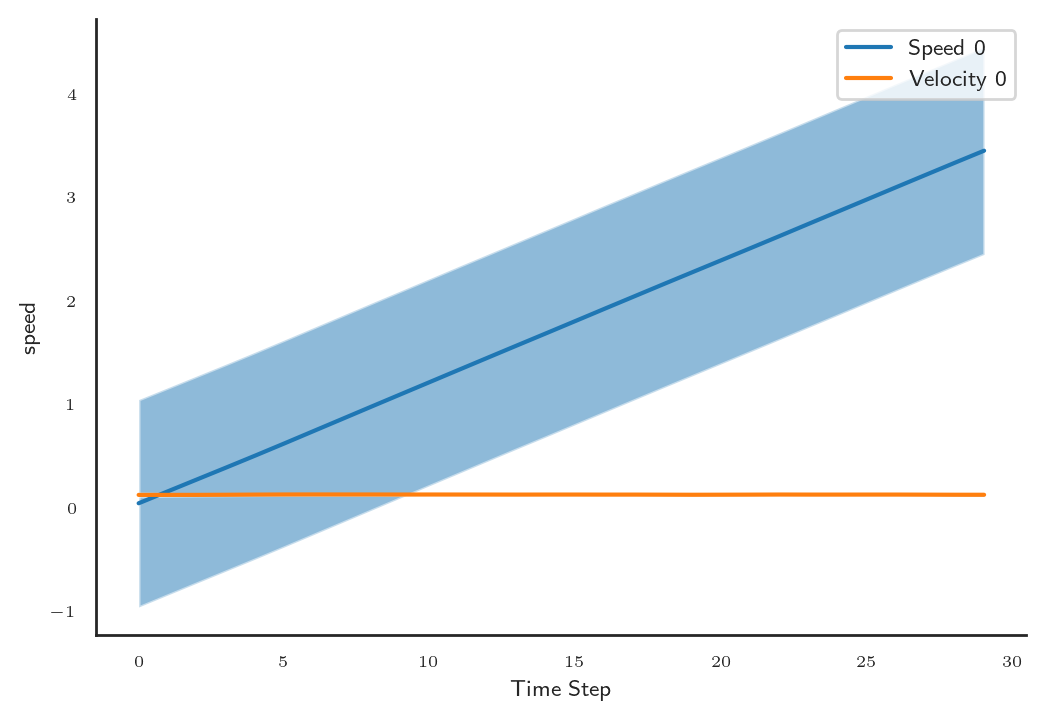

In [19]:
fig = plt.figure(figsize=(6,4))
idata.plot_time_series_posterior(variable_name="common_cause", ax=fig.gca(), include_bands=True, marker=None, dimension=0, label="Speed")
idata.plot_time_series_posterior(variable_name="common_cause", ax=fig.gca(), include_bands=True, marker=None, dimension=1, label="Velocity")
# plot_common_cause(data_low_c_and_cc, fig.gca())
plt.legend()